In [147]:
#Best Library for Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use("fivethirtyeight")

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error

# Regression
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

In [148]:
def metric(y,y0):
    assert len(y)==len(y0)
    return 100-np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0),2)))

def metric_lgb(y_pred,data):
    y_true = data.get_label()
    result = metric(y_true,y_pred)
    
    return '100-rmse', result,True

In [149]:
train_1 = pd.read_csv("train.csv")
test_1 = pd.read_csv("test.csv")

# print("Train Shape : {}\nTest Shape: {}\nSub Shape: {}".format(train_1.shape, test_1.shape))

In [150]:
print(f"Train :{train_1.shape} , Test :{test_1.shape}")

Train :(32165, 8) , Test :(10760, 7)


In [151]:
train = train_1.copy()
test = test_1.copy()

In [152]:
train.head(2)

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,8.022969
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,7.858458


In [153]:
train.columns

Index(['patient_id', 'name_of_drug', 'use_case_for_drug', 'review_by_patient',
       'effectiveness_rating', 'drug_approved_by_UIC',
       'number_of_times_prescribed', 'base_score'],
      dtype='object')

In [154]:
delete = ['review_by_patient','patient_id','name_of_drug','drug_approved_by_UIC','use_case_for_drug']
dataset = [train,test]
for x in dataset:
    for i in delete:
        del x[i]

In [155]:
train.head()

,effectiveness_rating,number_of_times_prescribed,base_score
0,9,27,8.022969
1,8,192,7.858458
2,5,17,6.341969
3,9,37,6.590176
4,2,43,6.144782


In [156]:
trainX, validX = train_test_split(train, test_size=0.2, shuffle=False, random_state=13)
print("Train Shape : {}\nValid Shape : {}".format(trainX.shape, validX.shape))

Train Shape : (25732, 3)
Valid Shape : (6433, 3)


In [157]:
def baseliner(train, features, target, cv=3, metric=make_scorer(metric, True)):
    print("Baseliner Models(All)")
    eval_dict = {}
    models = [
#         KNeighborsRegressor(), GaussianNB(), 
        lgb.LGBMRegressor(), ExtraTreesRegressor(), xgb.XGBRegressor(objective='reg:squarederror'), 
        cat.CatBoostRegressor(verbose=0), GradientBoostingRegressor(), RandomForestRegressor(), 
        LinearRegression(), DecisionTreeRegressor(), ExtraTreeRegressor(), AdaBoostRegressor(), 
        BaggingRegressor(), ElasticNet(), Lasso(), Ridge(), 
        ] #SVR(), 

    print("sklearn Model Name  \t  CV")
    print("--" * 50)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}

        results = cross_val_score(model, train[features], train[target], cv=cv, scoring=metric)
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t %.4f \t" % (
            model_name[:21], eval_dict[model_name]['cv']))

In [158]:
tscv = TimeSeriesSplit(n_splits=3)
target = 'base_score'

In [159]:
feat = train.columns.to_list()
feat.remove(target)

In [160]:
baseliner(train,feat,target,cv=tscv,metric=make_scorer(metric,True))

Baseliner Models(All)
sklearn Model Name  	  CV
----------------------------------------------------------------------------------------------------
LGBMRegressor 	 99.9584 	
ExtraTreesRegressor 	 99.9689 	
XGBRegressor 	 99.9029 	
<catboost.core.CatBoo 	 99.9501 	
GradientBoostingRegre 	 99.9024 	
RandomForestRegressor 	 99.9694 	
LinearRegression 	 99.7648 	
DecisionTreeRegressor 	 99.9685 	
ExtraTreeRegressor 	 99.9634 	
AdaBoostRegressor 	 99.8204 	
BaggingRegressor 	 99.9680 	
ElasticNet 	 99.7628 	
Lasso 	 99.7597 	
Ridge 	 99.7648 	


In [161]:
def lgb_model(train, features, target, ts=False, plot=True):
    evals_result = {}
    trainX, validX, trainY, validY = train_test_split(train[features], train[target], shuffle=False, test_size=0.2, random_state=13)
    print("LGB Model")
    lgb_train_set = lgb.Dataset(trainX, label=trainY)
    lgb_valid_set = lgb.Dataset(validX, label=validY)

    MAX_ROUNDS = 1111
    lgb_params = {
        "boosting": 'dart',
        "learning_rate": 0.1,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "regression",
    }

    lgb_model = lgb.train(
        lgb_params,
        train_set=lgb_train_set,
        valid_sets=[lgb_train_set, lgb_valid_set],
        early_stopping_rounds=250,
        verbose_eval=100,
        evals_result=evals_result,
        feval=metric_lgb # New metric to be optimised
    )
    if plot:
        lgb.plot_importance(lgb_model, figsize=(24, 24))
        lgb.plot_metric(evals_result, metric='100-rmse')

    return lgb_model, lgb_model.best_score

LGB Model
[100]	training's l2: 1.20142	training's 100-rmse: 99.8539	valid_1's l2: 1.19407	valid_1's 100-rmse: 99.8548
[200]	training's l2: 0.54484	training's 100-rmse: 99.9011	valid_1's l2: 0.538642	valid_1's 100-rmse: 99.9022
[300]	training's l2: 0.226471	training's 100-rmse: 99.9337	valid_1's l2: 0.223613	valid_1's 100-rmse: 99.9348
[400]	training's l2: 0.125644	training's 100-rmse: 99.9486	valid_1's l2: 0.124676	valid_1's 100-rmse: 99.9496
[500]	training's l2: 0.0956961	training's 100-rmse: 99.9543	valid_1's l2: 0.0960486	valid_1's 100-rmse: 99.9549
[600]	training's l2: 0.063724	training's 100-rmse: 99.9608	valid_1's l2: 0.0648562	valid_1's 100-rmse: 99.9611
[700]	training's l2: 0.0733747	training's 100-rmse: 99.9596	valid_1's l2: 0.0740834	valid_1's 100-rmse: 99.96
[800]	training's l2: 0.0524562	training's 100-rmse: 99.9639	valid_1's l2: 0.0537357	valid_1's 100-rmse: 99.9642
[900]	training's l2: 0.0387296	training's 100-rmse: 99.969	valid_1's l2: 0.0408722	valid_1's 100-rmse: 99.96

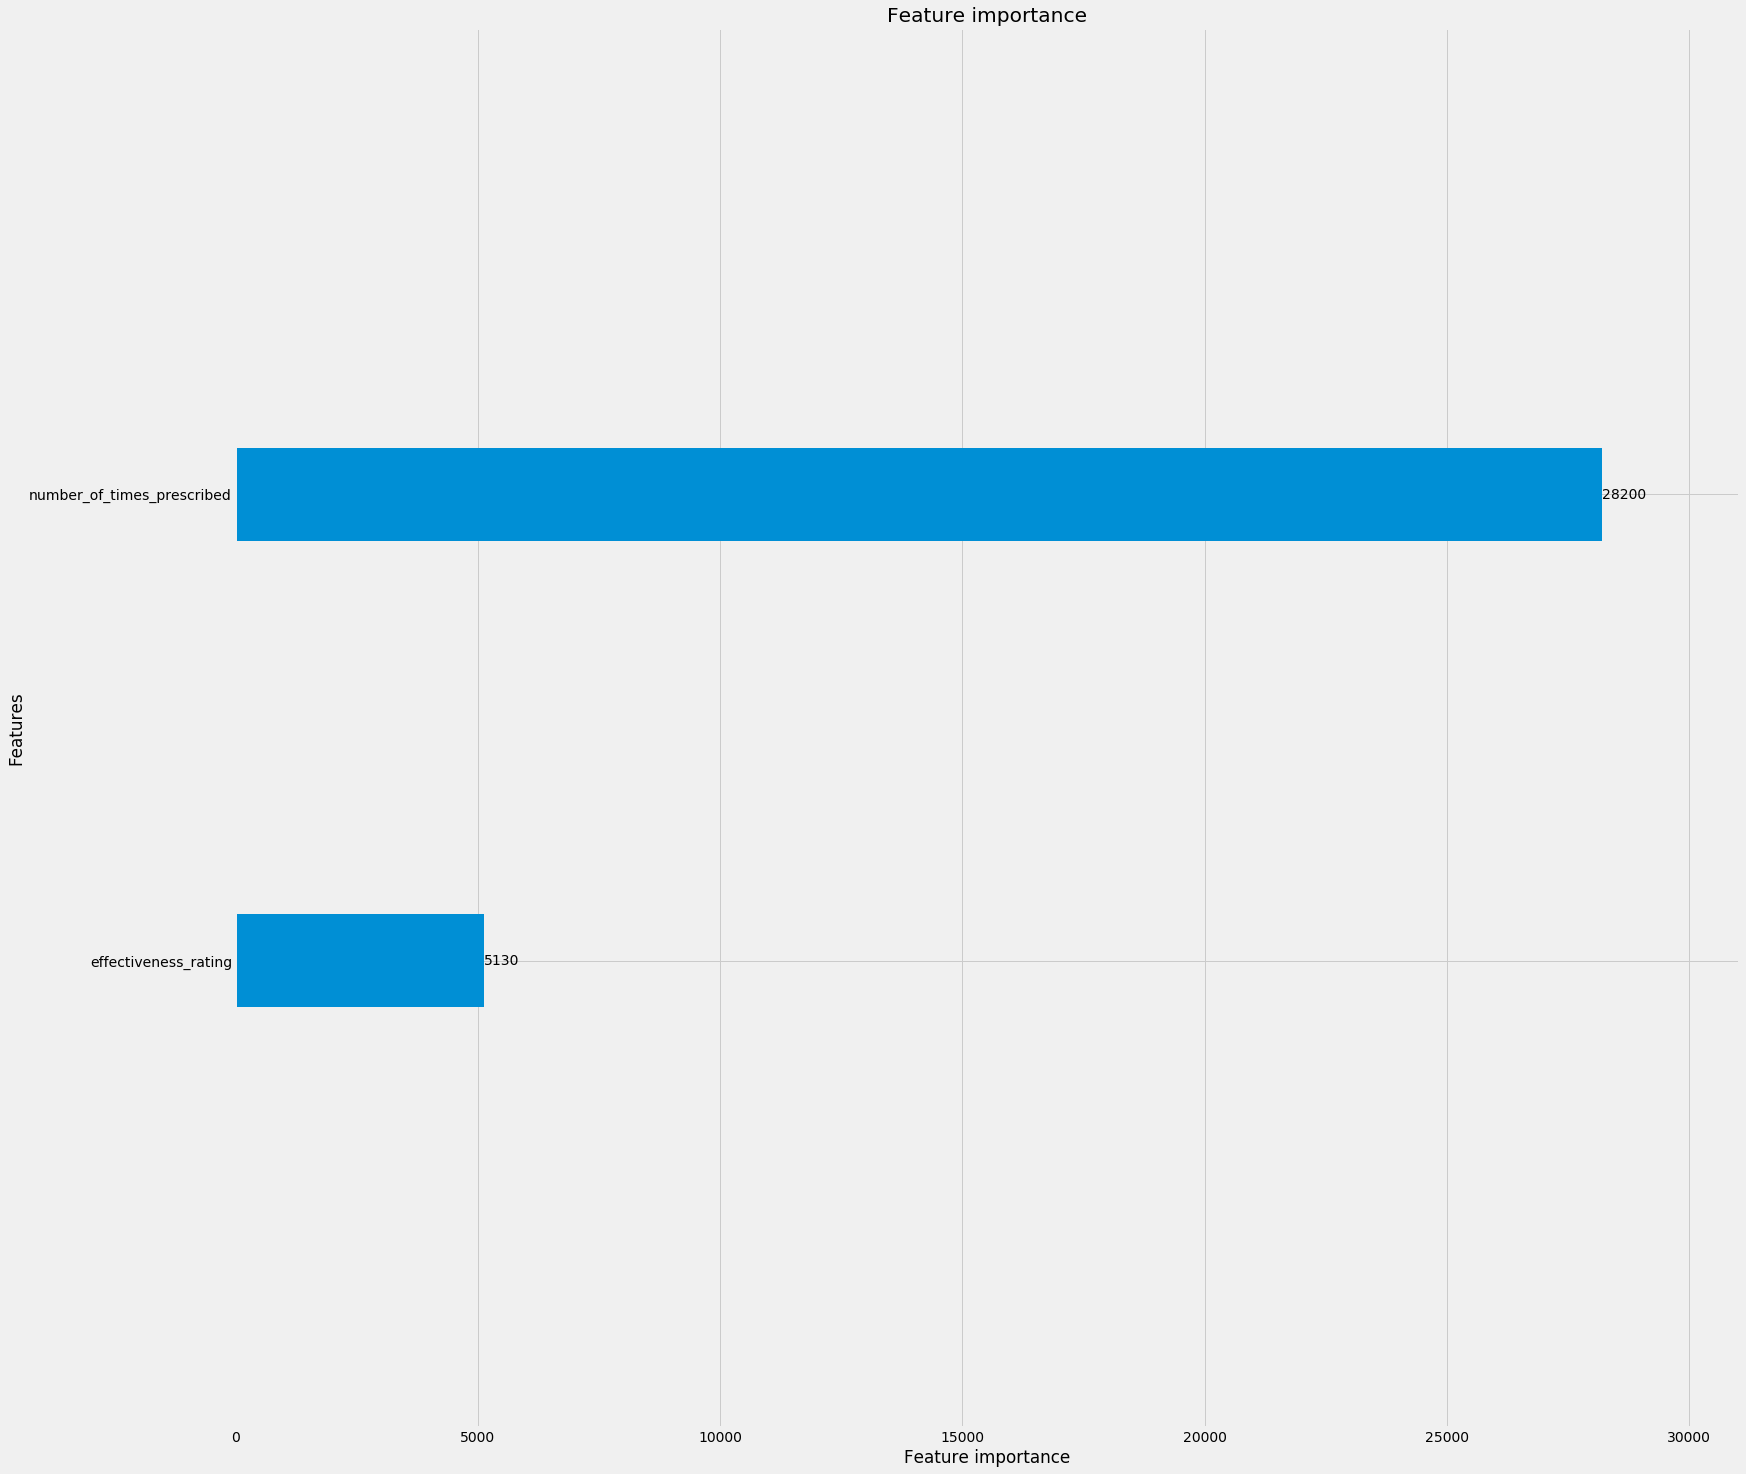

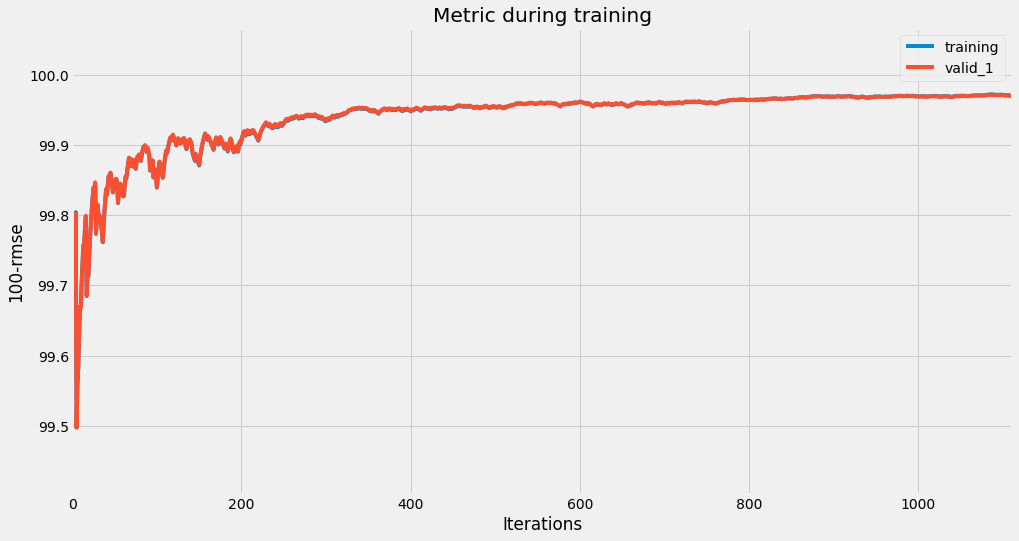

In [162]:
lgbM, score = lgb_model(train,feat,target,True,True)

In [163]:
lgbtrain = lgb.Dataset(train[feat],label = train[target])

In [164]:
MAX_ROUNDS = 1111
lgb_params = {
    "boosting": 'dart',
    "learning_rate": 0.1,
    "nthread": -1,
    "seed": 13,
    "num_boost_round": MAX_ROUNDS,
    "objective": "regression",
    'min_split_gain': 0,
}

In [165]:
lgb_model = lgb.train(
    lgb_params,
    train_set=lgbtrain,
    verbose_eval=100,
    feval=metric_lgb, # New metric to be optimised
)

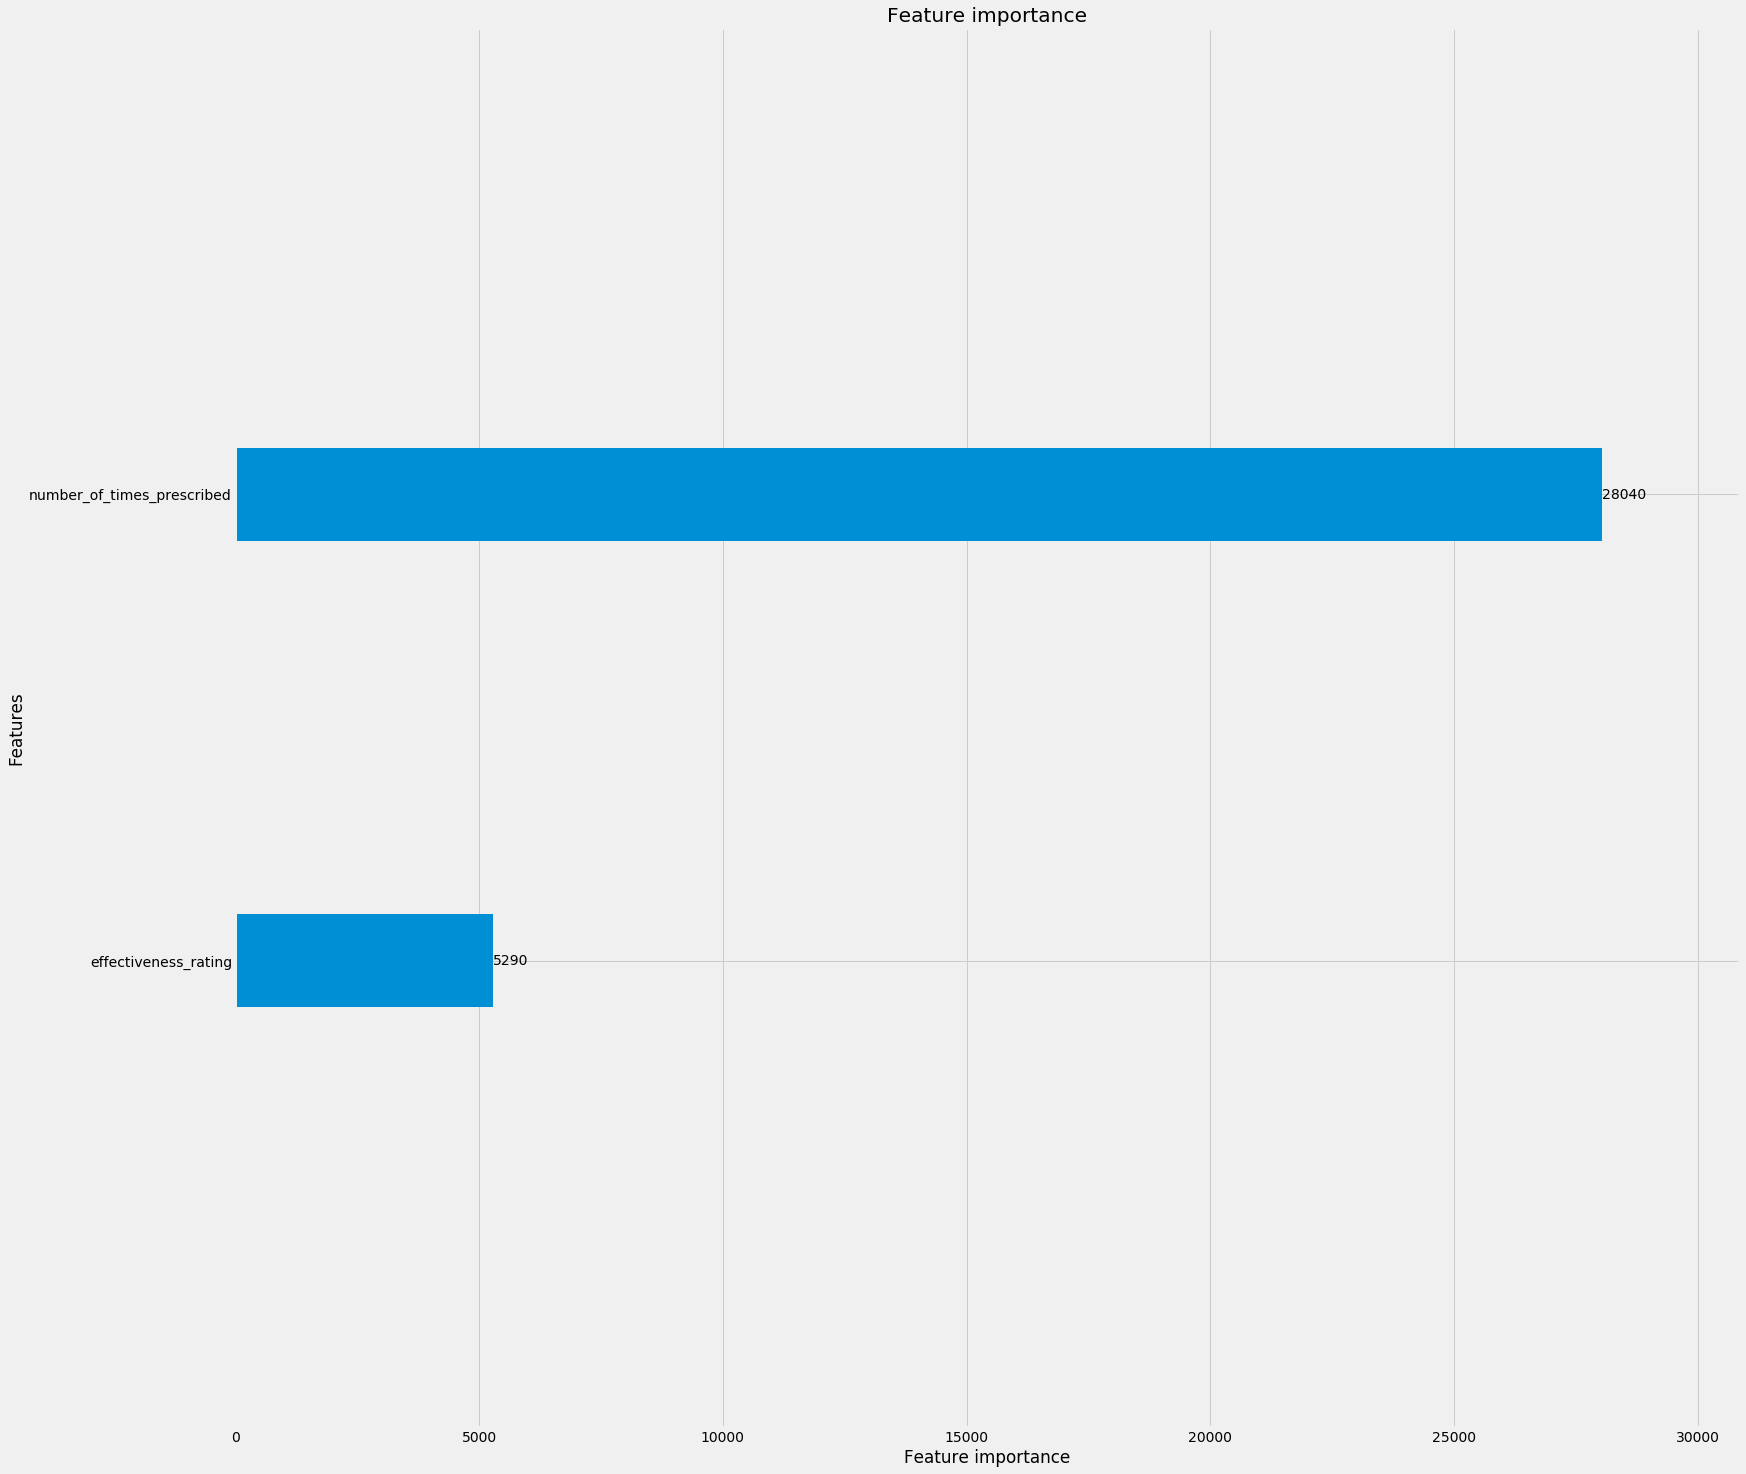

In [166]:
lgb.plot_importance(lgb_model, figsize=(24, 24))

In [167]:
y_preds = lgb_model.predict(test[feat])
test[target] = y_preds
test[target].head()

0    8.566827
1    8.520621
2    5.879881
3    5.877688
4    5.307621
Name: base_score, dtype: float64

In [168]:
ans = []
for i in range(len(y_preds)):
    ans.append(round(y_preds[i],2))

In [169]:
sub = test_1['patient_id']
sub = pd.DataFrame(sub)
sub['base_score'] = ans

In [170]:
sub.head()

,patient_id,base_score
0,163740,8.57
1,39293,8.52
2,208087,5.88
3,23295,5.88
4,97013,5.31


In [171]:
sub.to_csv("sub.csv",index=False)